<a href="https://colab.research.google.com/github/jpisarek/background-in-image-classification/blob/master/master_thesis_v4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from os.path import join
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications import VGG19, VGG16, ResNet50
from keras.layers import Flatten, Dense, Dropout, Softmax, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Model
from tensorflow.keras import regularizers

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name = '/device:GPU:0'

In [3]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# Wczytanie i wektoryzacja danych

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Praca\ magisterska/Datasets/Train/original_dataset.zip -d /dataset

In [ ]:
!unzip drive/MyDrive/Praca\ magisterska/Datasets/Train/original_cropped.zip -d /dataset

In [ ]:
!unzip drive/MyDrive/Praca\ magisterska/Datasets/Test/test_original_dataset.zip -d /dataset/original
!mv /dataset/original/test_original_dataset/test /dataset/original
!rmdir /dataset/original/test_original_dataset

In [9]:
dataset_dir = "/dataset/original/train"
dataset_dir_val = "/dataset/original/val"
dataset_dir_test = "/dataset/original/test"

dataset_dir_cropped = "/dataset/original_cropped/train"
dataset_dir_val_cropped = "/dataset/original_cropped/val"
input_size =(224, 224, 3)

In [10]:
classes =[]
for f in os.listdir(dataset_dir):
        if not f.startswith('.'):
            classes.append(f)
classes
classes.sort()
classes

['00_dog',
 '01_bird',
 '02_wheeled vehicle',
 '03_reptile',
 '04_carnivore',
 '05_insect',
 '06_musical instrument',
 '07_primate',
 '08_fish']

In [11]:
idx_classes_dict = dict(enumerate(classes))
classes_idx_dict = {v: k for k, v in idx_classes_dict.items()}
idx_classes_dict

{0: '00_dog',
 1: '01_bird',
 2: '02_wheeled vehicle',
 3: '03_reptile',
 4: '04_carnivore',
 5: '05_insect',
 6: '06_musical instrument',
 7: '07_primate',
 8: '08_fish'}

In [12]:
out_dir: str = "/dataset/original"

train_dir_main = os.path.join(out_dir, 'train')
val_dir_main = os.path.join(out_dir, 'val')
test_dir_main = os.path.join(out_dir, 'test')

Text(0.5, 1.0, 'Number of training images per category:')

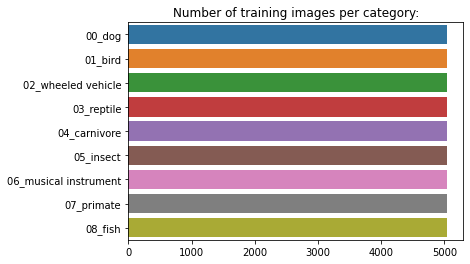

In [13]:
import seaborn as sns

category_names = sorted(os.listdir(train_dir_main))
number_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = train_dir_main + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))   
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

# Croppowanie datasetu

In [ ]:
from PIL import Image
import cv2
from IPython.display import display

for dir in os.listdir(dataset_dir_val):
  for file in os.listdir(dataset_dir_val + '/' + dir):

    print(dir)
    print(file)

    file_path = os.path.join(dataset_dir_val, dir, file)
    print(file_path)

    crop_size = (224, 224)
    img_stat = cv2.imread(file_path)
    img = Image.open(file_path)
    print(img_stat.shape)

    height, width = img_stat.shape[0], img_stat.shape[1]
    dy, dx = crop_size 
    start_y = (height - dy) // 2
    start_x = (width - dx) // 2
    end_x = start_x + 224
    end_y = start_y + 224

    cropped = img.crop((start_x, start_y, end_x, end_y))

    # display(img,cropped)
    
    cropped.save(file_path)

In [ ]:
!zip -r /content/drive/MyDrive/Praca\ magisterska/archivename.zip /dataset/original/train

In [ ]:
!zip -r /content/drive/MyDrive/Praca\ magisterska/archivename_val_original.zip /dataset/original/val

# Preprocessing danych - ImageDataGenerator

In [61]:
#from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

#train_datagen = ImageDataGenerator(rescale=1./ 255.,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   vertical_flip=True)



#train_datagen = ImageDataGenerator( rescale=1./ 255.,
 #                                   shear_range = 0.2,
  #                                  vertical_flip=True,
   #                                 zoom_range=0.1,
    #                                preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory(dataset_dir_cropped,
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical'
                                                 )

validation_generator = test_datagen.flow_from_directory(
                                                dataset_dir_val_cropped, 
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False
                                                ) 

test_generator = test_datagen.flow_from_directory(
                                                dataset_dir_test, 
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False
                                                )

Found 45405 images belonging to 9 classes.
Found 4185 images belonging to 9 classes.
Found 4051 images belonging to 9 classes.


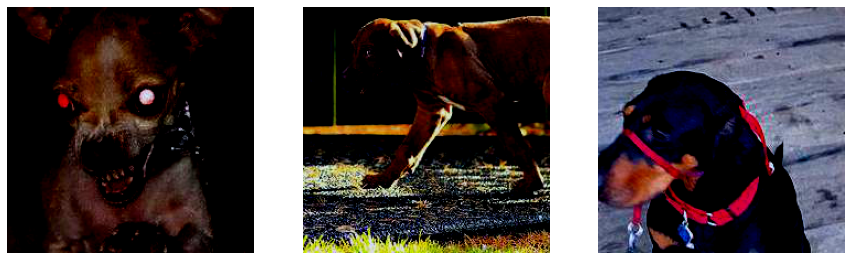

In [62]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

for i in range(3):
  image = next(validation_generator)[0][1]
  image = image/np.amax(image)
  image = np.clip(image, 0, 1)
  RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ax[i].imshow(RGB_img)
  ax[i].axis('off')

# Architektury

## Transfer learning sieci ResNet

In [64]:
def resNet(input_shape, classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(32,activation='relu')(x)
    x = Dense(16,activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(classes, activation='softmax')(x) #final layer with softmax activation
    model = Model(inputs=base_model.input,outputs=preds)

    # for l in base_model.layers:
    #   l.trainable = False

    for layer in base_model.layers[:81]:
      layer.trainable = False
    for layer in base_model.layers[81:]:
      layer.trainable = True

    # model.layers[0].trainable=False

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-5),   
                  metrics=['acc'])
    return model

model = resNet(input_size, 9)

In [65]:
from keras.callbacks import ModelCheckpoint

learning_rate = 1e-5
checkpoint = ModelCheckpoint("drive/MyDrive/Praca magisterska/classifier_resNet_v3.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [66]:
step_size_train = train_generator.n/train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size

fit_history = model.fit_generator(train_generator,
                     steps_per_epoch=step_size_train,
                     epochs=10,
                     validation_data=validation_generator,
                     validation_steps=step_size_val,
                     callbacks = [checkpoint],
                     verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1418/1418 [==============================] - 171s 116ms/step - loss: 1.7119 - acc: 0.3792 - val_loss: 0.4246 - val_acc: 0.9120

Epoch 00001: val_acc improved from -inf to 0.91202, saving model to drive/MyDrive/Praca magisterska/classifier_resNet_v3.h5
Epoch 2/10
1418/1418 [==============================] - 164s 115ms/step - loss: 0.7913 - acc: 0.7216 - val_loss: 0.2888 - val_acc: 0.9322

Epoch 00002: val_acc improved from 0.91202 to 0.93221, saving model to drive/MyDrive/Praca magisterska/classifier_resNet_v3.h5
Epoch 3/10
1418/1418 [==============================] - 164s 115ms/step - loss: 0.5954 - acc: 0.7727 - val_loss: 0.2760 - val_acc: 0.9368

Epoch 00003: val_acc improved from 0.93221 to 0.93678, saving model to drive/MyDrive/Praca magisterska/classifier_resNet_v3.h5
Epoch 4/10
1418/1418 [==============================] - 164s 115ms/step - loss: 0.4988 - acc: 0.7997 - val_loss: 0.2790 - val_acc: 0.9394

Epoch 00004: val_acc improved from 0.93678 to 0.93942, saving mode

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
model.summary()

# Statystyki z trenowania

In [67]:
from tensorflow.python.keras.models import load_model
model = load_model("drive/MyDrive/Praca magisterska/classifier_resNet_v3.h5")

In [68]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


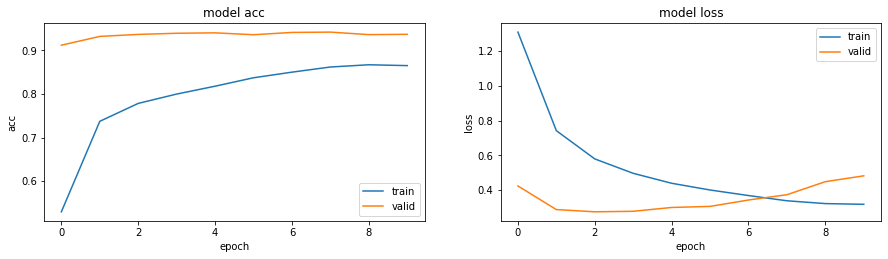

<Figure size 432x288 with 0 Axes>

In [69]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
plt.savefig("drive/MyDrive/Praca magisterska/Weight/ResNet_original.png")

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, figname,
                          normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
      cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print("Confusion matrix, without normalization")
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
  #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(figname)


In [ ]:
#!mkdir dataset_only_fg

In [ ]:
#!unzip drive/MyDrive/Praca\ magisterska/only_fg.zip -d /dataset_only_fg

In [ ]:
#background_test_dir: str = "/dataset_only_fg/only_fg/val"

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion matrix, without normalization


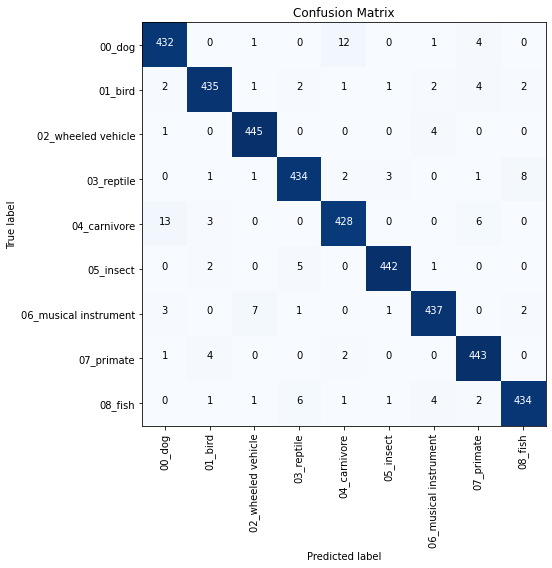

In [73]:
from sklearn.metrics import confusion_matrix

# test_datagen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_generator2 = test_datagen2.flow_from_directory(
#                                                 background_test_dir, 
#                                                 target_size=(224,224),
#                                                 batch_size=8,
#                                                 class_mode='categorical',
#                                                 shuffle=False
#                                                 )

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'drive/MyDrive/Praca magisterska/Weight/confusion_matrix_original_cropped')

In [74]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 97.0% 


# Zapis modelu 

In [34]:
score=model.evaluate(validation_generator, verbose=1)
print('Validation loss: ', score[0])
print('Validation accuracy: ', score[1])

131/131 [==============================] - 10s 71ms/step - loss: 0.2135 - acc: 0.9481
Validation loss:  0.2134609818458557
Validation accuracy:  0.9481481313705444


In [75]:
from keras.models import model_from_json

model_json = model.to_json()
with open("drive/MyDrive/Praca magisterska/Weight/ResNet_original_81.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("drive/MyDrive/Praca magisterska/Weight/ResNet_original_81.h5")

**--- Załadowanie wytrenowanego modelu ---**

In [76]:
from keras.models import model_from_json

json_file = open("drive/MyDrive/Praca magisterska/Weight/ResNet_original_81.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("drive/MyDrive/Praca magisterska/Weight/ResNet_original_81.h5", by_name=True, skip_mismatch=False)

loaded_model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=2e-4),   
                  metrics=['acc'])
score=loaded_model.evaluate(test_generator, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
score_val=loaded_model.evaluate(validation_generator, verbose=1)
print('Test loss: ', score_val[0])
print('Test accuracy: ', score_val[1])

127/127 [==============================] - 10s 66ms/step - loss: 0.2138 - acc: 0.9668
Test loss:  0.18210604786872864
Test accuracy:  0.9701308608055115
131/131 [==============================] - 9s 67ms/step - loss: 0.3722 - acc: 0.9424
Test loss:  0.37222933769226074
Test accuracy:  0.9424133896827698


# Załadowanie danych testowych z folderu "test" do sprawdzenia predykcji wytrenowanej sieci

In [ ]:
!pip install --upgrade tf-keras-vis

In [78]:
def _image_to_array(filename, target_size=input_size):
    img = Image.open(filename)
    img.load()
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size)
    x = np.asarray(img, dtype="int32")
    return x

In [79]:
visualization_dir_main = "drive/MyDrive/Praca magisterska/Datasets/Visualization"
visualization_dir_main

'drive/MyDrive/Praca magisterska/Datasets/Visualization'

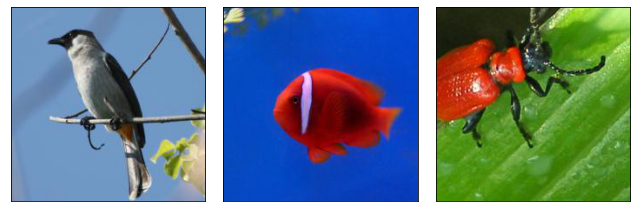

In [80]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import glob

files = glob.glob(visualization_dir_main + '/*')

images = []
image_titles = []

for file in files:
    image = _image_to_array(file, input_size[:2])
    images.append(image)
    image_titles.append(os.path.basename(file))
images = np.array(images)

X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    # ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [81]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][1], output[1][8], output[2][5])

In [82]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [ ]:
!nvidia-smi

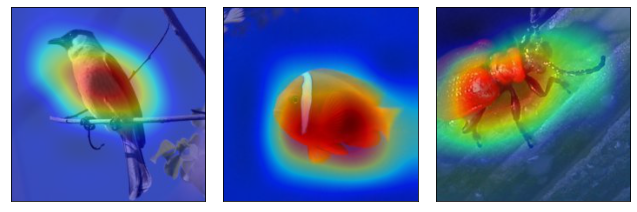

In [84]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

# Create Gradcam object
gradcam = Gradcam(loaded_model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    # ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

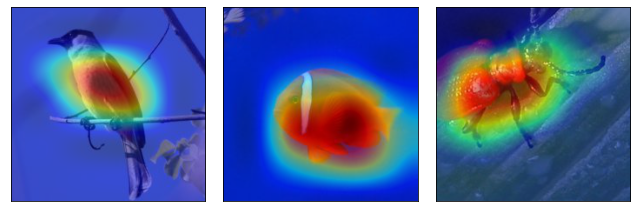

In [85]:
from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object, Just only repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(loaded_model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM++
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

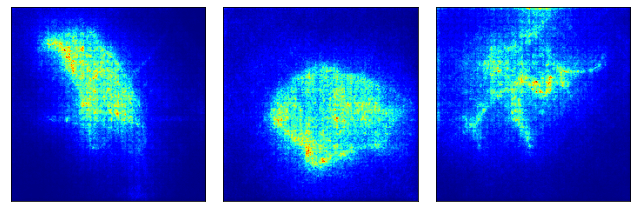

In [87]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(loaded_model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    # ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
# plt.savefig('images/smoothgrad.png')
plt.show()

# Visualizing Dense layer

In [114]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [115]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(loaded_model,
                                                 model_modifier,
                                                 clone=False)

In [116]:
def loss(output):
    return (output[0, 1], output[1, 8], output[2, 5])

In [117]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

In [ ]:
from tf_keras_vis.utils.callbacks import Print

# Do 500 iterations and Generate an optimizing animation
activations = activation_maximization(loss,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

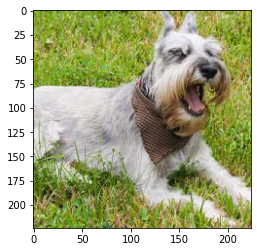

[[9.9610126e-01 4.7830822e-06 2.6278788e-11 4.3858431e-04 5.8861850e-05
  3.3718164e-03 6.8632750e-07 1.9669119e-06 2.1917402e-05]]
[0]
Zdjęcie należy do klasy: 00_dog


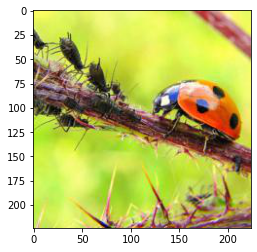

[[2.3804327e-02 7.3275110e-04 1.7402571e-04 2.8331189e-03 3.5115040e-03
  9.3061715e-01 4.2748861e-03 4.2570950e-04 3.3626556e-02]]
[5]
Zdjęcie należy do klasy: 05_insect


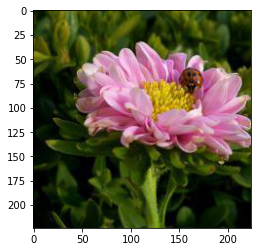

[[4.8812334e-03 4.8981299e-05 7.0270278e-07 4.1851919e-04 1.1266230e-04
  9.9428314e-01 6.8343958e-05 1.7636412e-05 1.6873400e-04]]
[5]
Zdjęcie należy do klasy: 05_insect


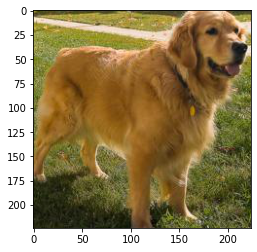

[[9.8988873e-01 4.9162518e-05 3.0815295e-09 1.0408270e-03 2.3502042e-04
  8.7100156e-03 8.3616578e-06 1.3861292e-05 5.4075364e-05]]
[0]
Zdjęcie należy do klasy: 00_dog


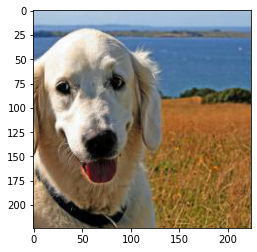

[[9.9707866e-01 3.5892651e-06 5.3991086e-11 3.3882094e-04 8.6060980e-05
  2.4858308e-03 6.8421235e-07 1.6960973e-06 4.6815030e-06]]
[0]
Zdjęcie należy do klasy: 00_dog


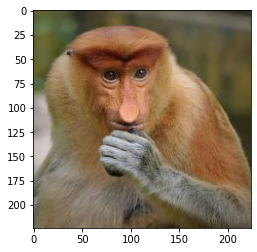

[[8.3382012e-08 1.9614836e-06 1.9210386e-12 1.3566524e-06 2.0847952e-02
  4.9022863e-13 4.3077621e-06 9.7914439e-01 9.2468583e-10]]
[7]
Zdjęcie należy do klasy: 07_primate


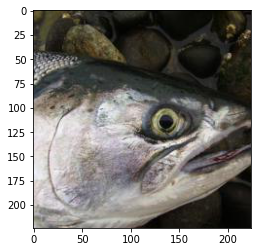

[[4.4039544e-03 3.3229948e-09 7.8202820e-16 6.2509853e-06 1.6025695e-10
  6.1620900e-04 5.2763298e-05 2.4317924e-11 9.9492079e-01]]
[8]
Zdjęcie należy do klasy: 08_fish


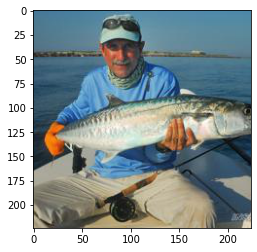

[[7.69239245e-03 6.09901551e-09 1.91255338e-15 1.40416305e-05
  2.10358161e-10 7.01102312e-04 8.79852014e-05 5.10908087e-11
  9.91504490e-01]]
[8]
Zdjęcie należy do klasy: 08_fish


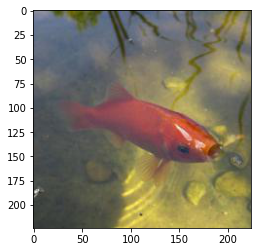

[[9.9548372e-03 9.1838723e-09 4.7595933e-15 2.1199538e-05 3.1993383e-10
  8.2169945e-04 1.2785725e-04 1.0219890e-10 9.8907441e-01]]
[8]
Zdjęcie należy do klasy: 08_fish


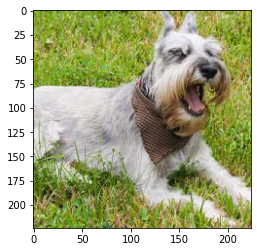

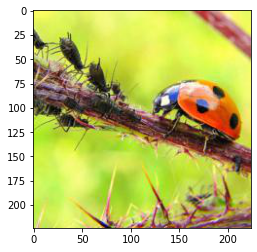

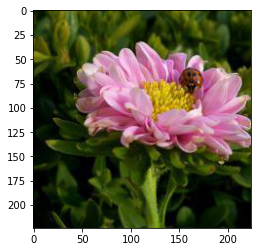

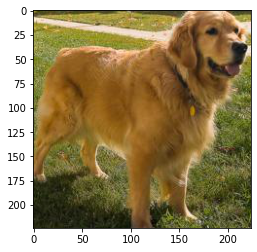

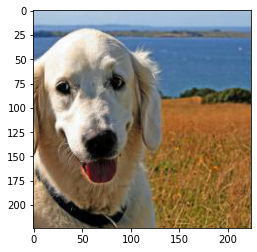

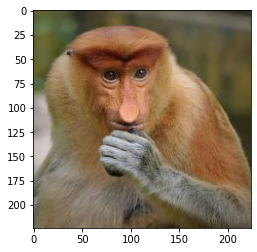

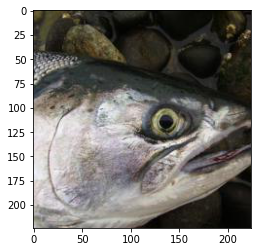

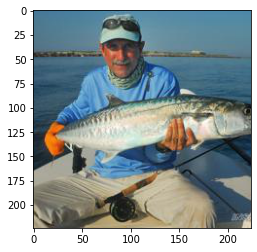

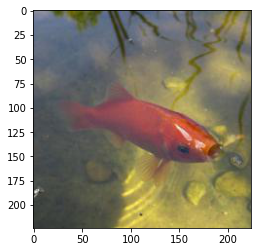

In [41]:
import matplotlib.pyplot as plt
import glob

files = glob.glob(visualization_dir_main + '/*')
# for dir in dirs:
#   files = glob.glob(dir + '/*')
for file in files:
    image = _image_to_array(file, input_size[:2])
    fig = plt.figure()
    plt.imshow(image)
    display(fig)
    image = np.expand_dims(image, axis=0) # macierz o rozmiarze wejściowym sieci
    y = model.predict(image)
    print(y) #wektor prawdopodobieństw

    print(np.argmax(y, axis=1)) # wyciągnięcie indeksu wartości, która jest najwyższa w wektorze y 
    predictedClass = np.argmax(y, axis=1)
    print("Zdjęcie należy do klasy: " + idx_classes_dict.get(predictedClass[0], '19'))   
    print("=================================================================")